In [188]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
matplotlib.rc('font', **{'size': 15})


src = 'AGLT2'
src = 'CERN-PROD'
dst = 'BNL-ATLAS'


#Create instance of ElasticSearch using the Atlas host server
es1 = Elasticsearch(hosts=[{'host':'atlas-kibana-2.mwt2.org', 'port':9200}],timeout=60)

In [189]:
query1 = '''{
    
  "size": 10000,
  "sort": [
    {
      "@timestamp": {
        "order": "random",
      }
    }
  ],
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "payload.src-rse:CERN* AND payload.dst-rse:BNL* AND event_type:transfer-done",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "@timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "fielddata_fields": [
    "@timestamp","duration"
  ]
}'''

In [190]:
import ast
import time
currentMilliTime = int(round(time.time()*1000))
milliWeek = 7*24*60*60*1000
milliTwoWeek = 2*7*24*60*60*1000
milliSixHour = 12*60*60*1000
milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
milliHalfDay = 12*60*60*1000

milliHour = 60*60*1000

In [191]:
#Get files day interval (stagger a little from current time to get more interesting data)
start = currentMilliTime - milliWeek
end = currentMilliTime

#Get important variables from response
fileSize = []
activity = []
startedAt = []
submittedAt = []
transferredAt = []
duration = []
fileTimestamp = []

startPart = start
endPart = start
hourSeg = 24*7

weekTimestamp = []
weekFileSize = []
weekActivity = []
weekStartedAt = []
weekSubmittedAt = []
weekTransferredAt = []

#Step through day, getting all data in range
for i in range(hourSeg):
    endPart += milliHour
    response = es1.search(index="rucio-events*", body=ast.literal_eval(query1%(startPart,endPart)), request_timeout=600)
    startPart = endPart + 1
    for r in response['hits']['hits']:
        fileTimestamp.append(r['fields']['@timestamp'])
        fileSize.append(r['_source']['payload']['file-size'])
        activity.append(r['_source']['payload']['activity'])
        startedAt.append(r['_source']['payload']['started_at'])
        submittedAt.append(r['_source']['payload']['submitted_at'])
        transferredAt.append(r['_source']['payload']['transferred_at'])
    
    #Get random indices in range of length of data vectors
    ind = np.random.choice(len(fileSize),size=100,replace=False)
    np.random.seed()
    
    #Get random sample of data
    
    weekTimestamp += [ fileTimestamp[i] for i in ind]
    weekFileSize += [ fileSize[i] for i in ind]
    weekActivity += [ activity[i] for i in ind]
    weekStartedAt += [ startedAt[i] for i in ind]
    weekSubmittedAt += [ submittedAt[i] for i in ind]
    weekTransferredAt += [ transferredAt[i] for i in ind]

    if i%24 == 0:
        print('Hey!')

    
#fileSize = np.array(fileSize)
#activity = np.array(activity)
#startedAt = np.array(startedAt)
#submittedAt = np.array(submittedAt)
#transferredAt = np.array(transferredAt)

Hey!
Hey!
Hey!
Hey!
Hey!
Hey!
Hey!


In [192]:

def get_ddm_data(es,src,dst,start,end,agg,field,timestamp=False):
    queryTemp = '''{
      "size": 0,
      "query": {
        "filtered": {
          "query": {
            "query_string": {
              "query": "src:%s AND dst:%s",
              "analyze_wildcard": True
            }
          },
          "filter": {
            "bool": {
              "must": [
                {
                  "range": {
                    "timestamp": {
                      "gte": %i,
                      "lte": %i,
                      "format": "epoch_millis"
                    }
                  }
                }
              ],
              "must_not": []
            }
          }
        }
      },
      "aggs": {
        "2": {
          "date_histogram": {
            "field": "timestamp",
            "interval": "1h",
            "time_zone": "Europe/Berlin",
            "min_doc_count": 1,
            "extended_bounds": {
              "min": %i,
              "max": %i
            }
          },
          "aggs": {
            "1": {
              "%s": {
                "field": "%s"
              }
            }
          }
        }
      }
    }'''
    query = ast.literal_eval(queryTemp%(src,dst,start,end,start,end,agg,field))
    response = es.search(index="atlas_ddm-metrics*", body=query, request_timeout=600)
    
    data = []
    if timestamp == False:
        for r in response['aggregations']['2']['buckets']:
            data.append(r['1']['value'])
        return np.array(data,dtype=np.float)
    
    elif timestamp == True:
        timestamp = []
        for r in response['aggregations']['2']['buckets']:
            data.append(r['1']['value'])
            timestamp.append(r['key'])
        return np.array(data,dtype=np.float),np.array(timestamp,dtype=np.float)

In [214]:
import time

tic = time.time()
#start and end left over from previous definition
#Get fields from another host

es2 = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)

agg = 'max'
queuedData,timestamp = get_ddm_data(es2,src,dst,start,end,agg,'queued-total',timestamp=True)
packetloss = get_ddm_data(es2,src,dst,start,end,agg,'packetloss')
dashThroughput1h = get_ddm_data(es2,src,dst,start,end,agg,'mbps-dashb-1h')
dashThroughput1d = get_ddm_data(es2,src,dst,start,end,agg,'mbps-dashb-1d')
ftsThroughput1h = get_ddm_data(es2,src,dst,start,end,agg,'mbps-fts-1h')
ftsThroughput1d = get_ddm_data(es2,src,dst,start,end,agg,'mbps-fts-1d')
faxThroughput1h = get_ddm_data(es2,src,dst,start,end,agg,'mbps-fax-1h')
faxThroughput1d = get_ddm_data(es2,src,dst,start,end,agg,'mbps-fax-1d')
doneTotal1h = get_ddm_data(es2,src,dst,start,end,agg,'done-total-1h')


print('Finished aggregating in %f seconds'%(time.time()-tic))

Finished aggregating in 3.783475 seconds


In [215]:
import datetime
from datetime import datetime

#Some useful functions for date conversion

def convertDateToDatetime(dates):
    '''
    Converts string dates to datetime objects
    '''
    datetimeDates = []
    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
        datetimeDates.append(epoch)
    return datetimeDates

def convertDateToMilliEpoch(dates):
    '''
    Converts string dates to milliEpoch values.
    '''
    epochDates = []
    zeroEpoch = datetime.utcfromtimestamp(0)    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
            
        epochDates.append((epoch - zeroEpoch).total_seconds() * 1000.0)
    return epochDates
        
        
    return datetimeDates

def getSecondsDifference(epochDatesStart,epochDatesFinal):
    diff = []
    for i in range(len(epochDatesStart)):
        diff.append((epochDatesFinal[i] - epochDatesStart[i]).total_seconds())
    
    return diff

In [216]:
#Convert string timestamps to usable quantities (each per-file, BTW)

timeInQueue = getSecondsDifference(convertDateToDatetime(weekSubmittedAt),
                                   convertDateToDatetime(weekStartedAt))
timeTotal = getSecondsDifference(convertDateToDatetime(weekSubmittedAt),
                                 convertDateToDatetime(weekTransferredAt))
timeInTransfer = getSecondsDifference(convertDateToDatetime(weekStartedAt),
                                      convertDateToDatetime(weekTransferredAt))

timeInTransfer = np.array(timeInTransfer)
timeTotal = np.array(timeTotal)
timeInQueue = np.array(timeInQueue)

In [217]:
#Get times that each file is submitted at

submittedTimes = np.array(convertDateToMilliEpoch(weekSubmittedAt))

#Get indices for sorting (use these indices to sort any ddm-metrics variables)
timeIndex = np.argsort(submittedTimes)
submittedTimes = submittedTimes[timeIndex]

#Sort according to monotonically increasing file-submitted timestamp
weekFileSize = np.array(weekFileSize)[timeIndex]
timeTotal = timeTotal[timeIndex]

In [218]:
#Get indices that relate the two timescales between metrics
binIndex = np.digitize(submittedTimes,timestamp)-1


In [219]:
queue = queuedData[binIndex]
loss = packetloss[binIndex]
times = timestamp[binIndex]
dash_through1h = dashThroughput1h[binIndex]
dash_through1d = dashThroughput1d[binIndex]
fts_through1d = ftsThroughput1d[binIndex]
fts_through1h = ftsThroughput1h[binIndex]
done_total1h = doneTotal1h[binIndex]
done_total1d = doneTotal1d[binIndex]


In [256]:
inputSample = np.squeeze(np.dstack((queue,done_total1h,weekFileSize,dash_through1h)))
outputSample = timeTotal

In [257]:
missing = np.isnan(np.sum(inputSample,axis=1))

beta_hat = np.linalg.lstsq(inputSample[~missing],outputSample[~missing])[0]

In [258]:
predictOutput = np.dot(inputSample,beta_hat)

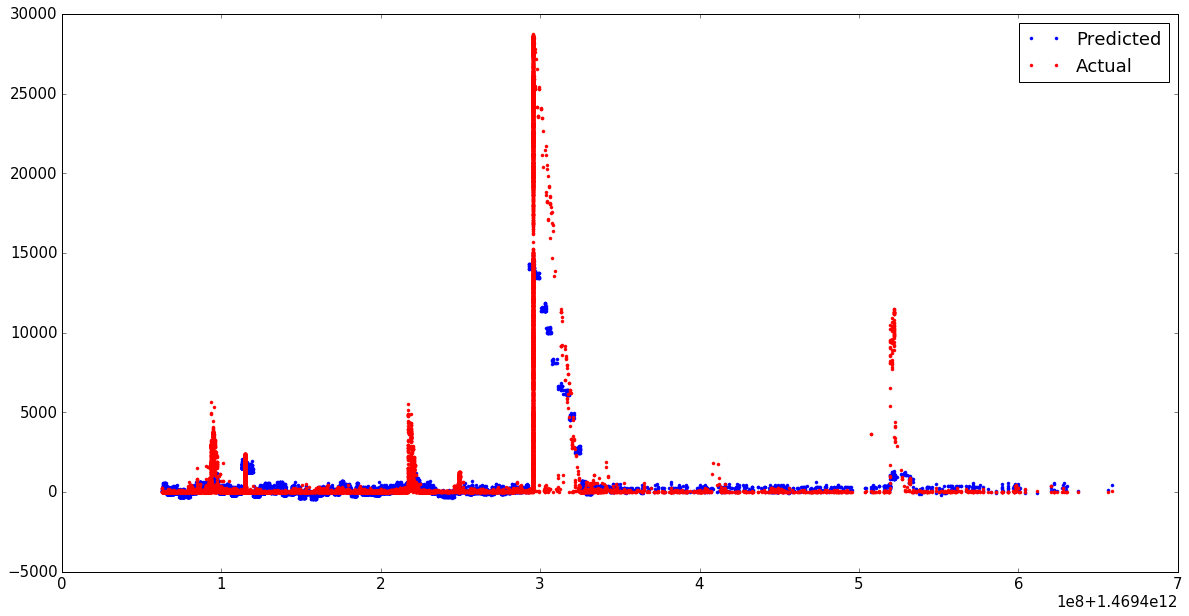

In [259]:
a,b = 0,len(submittedTimes)
plt.figure(figsize=(20,10))
plt.plot(submittedTimes[a:b],predictOutput[a:b],'b.',label='Predicted')
plt.plot(submittedTimes[a:b],outputSample[a:b],'r.',label='Actual')
plt.legend()